In [1]:
import pandas as pd

energy = pd.read_csv('energy_data.csv')
weather = pd.read_csv('weather_data.csv')

#turn to datetime values
weather['time'] = pd.to_datetime(weather['time'], unit='s')
energy['Date & Time'] = pd.to_datetime(energy['Date & Time'])

# Combine energy values by the hour
hourly_energy = energy.groupby(pd.Grouper(key='Date & Time', freq='1H')).sum().reset_index()
hourly_energy['Date'] = hourly_energy['Date & Time'].dt.date
hourly_energy = hourly_energy.rename(columns={'use [kW]': 'Hourly use [kW]'})
#print(hourly_energy)

# Convert energy values by the day
daily_energy = hourly_energy.groupby(hourly_energy['Date & Time'].dt.date)['Hourly use [kW]'].sum().reset_index()
daily_energy = daily_energy.rename(columns={'Date & Time': 'Date', 'Hourly use [kW]': 'Daily use [kW]'})
#print(daily_energy)

combined_energy = hourly_energy.merge(daily_energy, on='Date')
#print(combined_energy)

weather = weather.rename(columns={'time': 'Date & Time'})
daily_energy['Date'] = pd.to_datetime(daily_energy['Date'])
daily_energy_and_weather = daily_energy.merge(weather, left_on='Date', right_on='Date & Time')
print('Part 1:')
print(daily_energy_and_weather)

combined_data = combined_energy.merge(weather, on='Date & Time') # all hourly data with daily energy
combined_data['Date'] = pd.to_datetime(combined_data['Date'])

# Replace NaN values in 'cloudCover' with the mean value
combined_data['cloudCover'].fillna(combined_data['cloudCover'].mean(), inplace=True)

Part 1:
          Date  Daily use [kW]  temperature                 icon  humidity  \
0   2014-01-01       65.013592        34.98  partly-cloudy-night      0.64   
1   2014-01-02       32.305336        20.91          clear-night      0.57   
2   2014-01-03       31.164468         9.38                 snow      0.81   
3   2014-01-04       45.287782         1.72          clear-night      0.57   
4   2014-01-05       36.316643        19.69          clear-night      0.50   
..         ...             ...          ...                  ...       ...   
360 2014-12-27       35.046127        35.08          clear-night      0.74   
361 2014-12-28       37.695824        36.15          clear-night      0.80   
362 2014-12-29       28.675929        40.13          clear-night      0.63   
363 2014-12-30       31.514313        30.73          clear-night      0.51   
364 2014-12-31       28.674498        21.03          clear-night      0.46   

     visibility        summary  pressure  windSpeed  cl

Root Mean Squared Error (RMSE): 0.7586659245234664


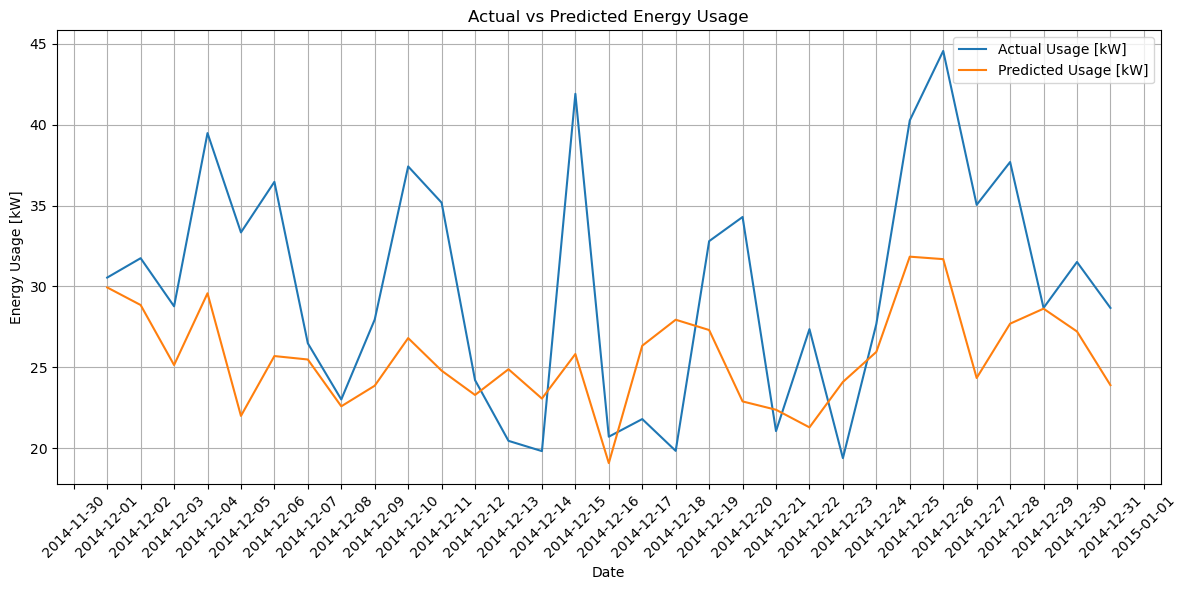

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Split the data into training and testing sets
#print(combined_data.columns)

X = combined_data[['Date', 'temperature', 'humidity', 'visibility', 'pressure', 'windSpeed', 
                   'cloudCover', 'windBearing', 'precipIntensity', 'dewPoint', 'precipProbability']]
y = combined_data[['Hourly use [kW]']]

# Filter non-December data for training
X_train = X[X['Date'].dt.month != 12].drop('Date', axis=1)
y_train = y[X['Date'].dt.month != 12].to_numpy()

# Filter December data for testing
X_test = X[X['Date'].dt.month == 12].drop('Date', axis=1)
y_test = y[X['Date'].dt.month == 12].to_numpy()

# Create and train the linear regression model
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)

predictions = regression_model.predict(X_test)

y_test = combined_data[combined_data['Date'].dt.month == 12]['Hourly use [kW]']
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Generate CSV file of predicted values
predicted_data = pd.DataFrame({'Date': combined_data[combined_data['Date'].dt.month == 12]['Date'], 'Predicted Usage [kW]': predictions.reshape(-1)})
daily_predictions = predicted_data.groupby('Date')['Predicted Usage [kW]'].sum().to_frame().reset_index()
daily_predictions.to_csv('linear_regression.csv', index=False)
#print(daily_predictions)

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

daily_december_energy = combined_data.groupby('Date')['Hourly use [kW]'].sum().to_frame().reset_index()
daily_december_energy = daily_december_energy[daily_december_energy['Date'].dt.month == 12]
daily_december_energy = daily_december_energy.rename(columns={'Hourly use [kW]': 'Daily use [kW]'})

# Plotting the real data and the predicted data
plt.figure(figsize=(12, 6))
plt.plot(daily_december_energy['Date'], daily_december_energy['Daily use [kW]'], label='Actual Usage [kW]')
plt.plot(daily_predictions['Date'], daily_predictions['Predicted Usage [kW]'], label='Predicted Usage [kW]')
plt.title('Actual vs Predicted Energy Usage')
plt.xlabel('Date')
plt.ylabel('Energy Usage [kW]')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format x-axis to show every day
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Set the x-axis to show every day
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.show()

F1 score: 1.0


C:\Users\jerem\AppData\Local\Temp\ipykernel_26560\572430689.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_weather['Date'] = daily_weather['Date & Time'].dt.date
c:\Users\jerem\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


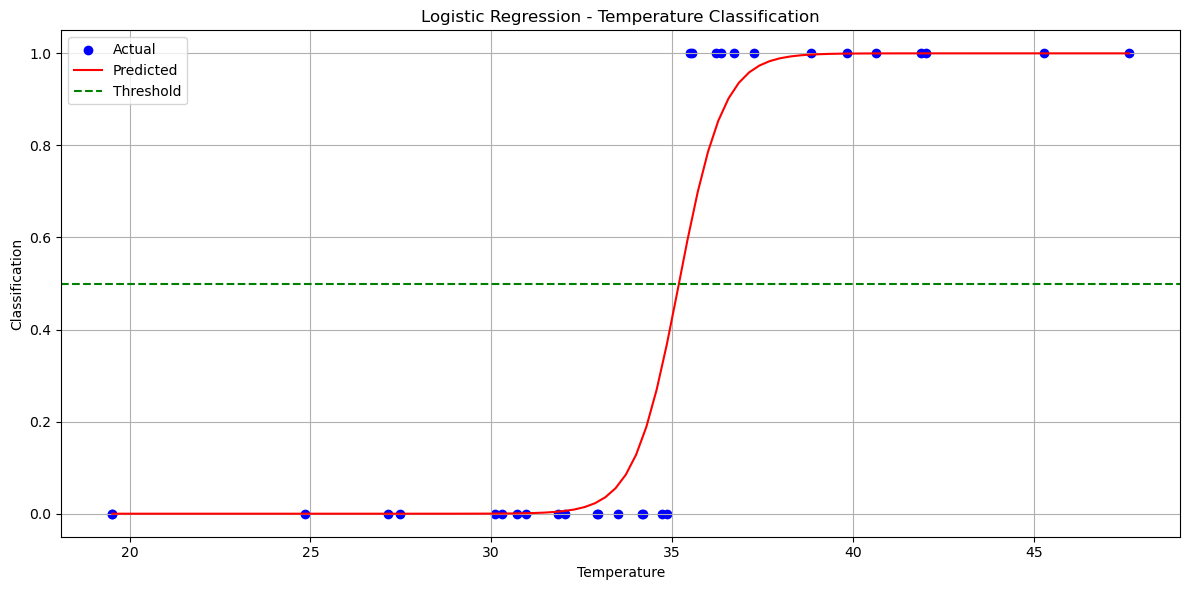

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

# Turn hourly weather into daily temperature
#print(weather.columns)
daily_weather = weather[['Date & Time', 'temperature']]
daily_weather['Date'] = daily_weather['Date & Time'].dt.date
daily_weather = daily_weather.groupby('Date')['temperature'].mean().to_frame().reset_index()
#print(daily_weather)

# Add a classification column and set x and y data
daily_weather['classification'] = (daily_weather['temperature'] >= 35).astype(int)
daily_weather['Date'] = pd.to_datetime(daily_weather['Date'])
december_weather_data = daily_weather[daily_weather['Date'].dt.month == 12]
#print(december_weather_data.head())
X = december_weather_data[['temperature']]
y = december_weather_data['classification']

model = LogisticRegression()
model.fit(X, y)
predictions = model.predict(X)

f1 = f1_score(y, predictions)
print(f"F1 score: {f1}")

classification_df = pd.DataFrame({'Date': december_weather_data['Date'], 'classification': predictions})

#print(classification_df)
classification_df.to_csv('logistic_regression.csv', index=False)

# Plotting the logistic regression model with the data
plt.figure(figsize=(12, 6))
plt.scatter(X, y, color='blue', label='Actual')
x_values = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
plt.plot(x_values, model.predict_proba(x_values)[:, 1], color='red', label='Predicted')
plt.axhline(y=0.5, color='green', linestyle='--', label='Threshold')
plt.title('Logistic Regression - Temperature Classification')
plt.xlabel('Temperature')
plt.ylabel('Classification')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Home Office Usage:
- max peaks at 9am and 1pm. On average, remains consistent through the day.
- maximum spikes at 5am, but is consistent every other hour.
Fridge Usage: It peaks at 9am and 1pm during the Day
- peaks at 8pm during the night time, probably from dinner.
- consistent throughout the day, but on average, spikes at 8am and 6pm


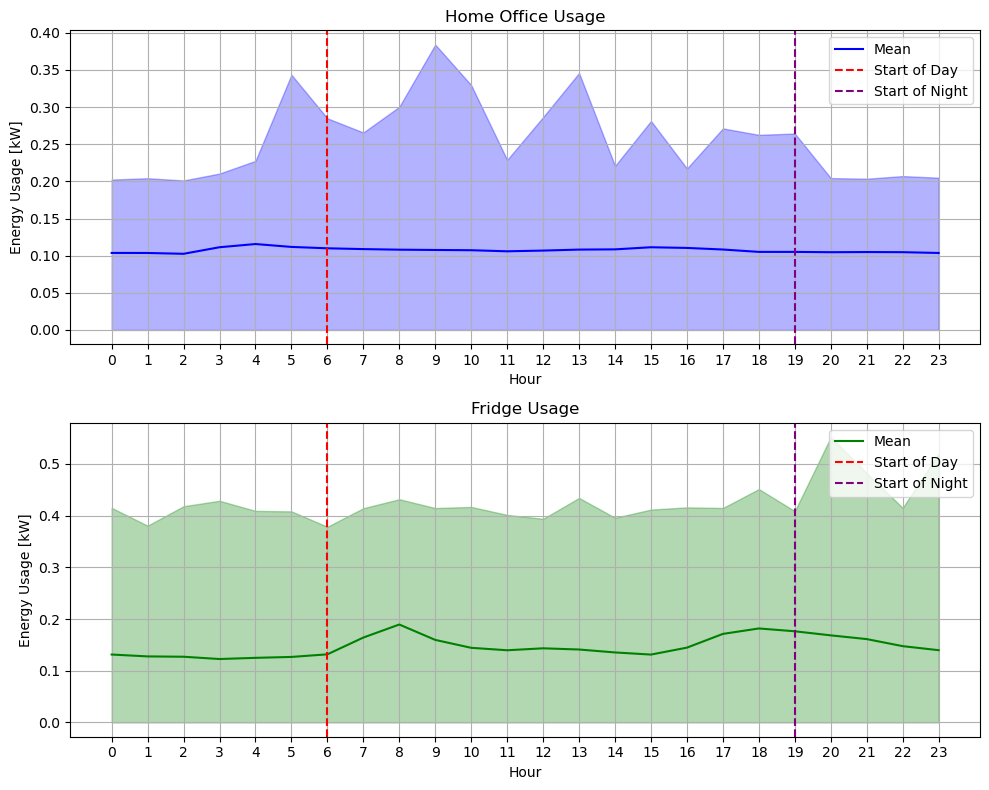

In [4]:
# Take important columns from hourly energy
hourly_energy = hourly_energy[['Date & Time', 'Home Office (R) [kW]', 'Fridge (R) [kW]',]]

# Group by hour and get descriptive stats for home office and fridge
home_office_stats = hourly_energy.groupby(hourly_energy['Date & Time'].dt.hour)['Home Office (R) [kW]'].describe()
fridge_stats = hourly_energy.groupby(hourly_energy['Date & Time'].dt.hour)['Fridge (R) [kW]'].describe()

# Extract time values for x-axis
x_hours = home_office_stats.index

# Plotting the trends with descriptive statistics
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Plot Home Office usage during day and night with descriptive statistics
axes[0].plot(x_hours, home_office_stats['mean'], color='blue', label='Mean')
axes[0].fill_between(x_hours, home_office_stats['min'], home_office_stats['max'], alpha=0.3, color='blue')
axes[0].axvline(6, color='red', linestyle='--', label='Start of Day')
axes[0].axvline(19, color='purple', linestyle='--', label='Start of Night')
axes[0].set_title('Home Office Usage')
axes[0].set_xlabel('Hour')
axes[0].set_ylabel('Energy Usage [kW]')
axes[0].set_xticks(x_hours)
axes[0].set_xticklabels(x_hours)
axes[0].legend()
axes[0].grid(True)

# Plot Fridge usage during day and night with descriptive statistics
axes[1].plot(x_hours, fridge_stats['mean'], color='green', label='Mean')
axes[1].fill_between(x_hours, fridge_stats['min'], fridge_stats['max'], alpha=0.3, color='green')
axes[1].axvline(6, color='red', linestyle='--', label='Start of Day')
axes[1].axvline(19, color='purple', linestyle='--', label='Start of Night')
axes[1].set_title('Fridge Usage')
axes[1].set_xlabel('Hour')
axes[1].set_ylabel('Energy Usage [kW]')
axes[1].set_xticks(x_hours)
axes[1].set_xticklabels(x_hours)
axes[1].legend()
axes[1].grid(True)

print('Home Office Usage:')
print('- max peaks at 9am and 1pm. On average, remains consistent through the day.')
print('- maximum spikes at 5am, but is consistent every other hour.')
print('Fridge Usage: It peaks at 9am and 1pm during the Day')
print('- peaks at 8pm during the night time, probably from dinner.')
print('- consistent throughout the day, but on average, spikes at 8am and 6pm')
plt.tight_layout()
plt.show()


